In this example, I am building an economic dispatch (ED) model from scratch. I utilize JuMP package of Julia to build linear programming (LP) optimization problem and Gurobi to solve the problem. 

In [1]:
#Importing necessary packages
using JuMP
using CSV
using DataFrames
using Gurobi
using Plots

In [2]:
#Reading generator, demand and transmission line datasets
Generators_df = CSV.read("Data/Generator_data.csv", DataFrame)
Demand_df = CSV.read("Data/Demand_data.csv", DataFrame)
Line_df = CSV.read("Data/Line_data.csv", DataFrame)

#Designating number of generators, nodes and lines
Num_Gens = size(Generators_df, 1)
Num_Nodes = size(Demand_df, 2)-1
Num_Lines = size(Line_df, 1)

#Saving important information as arrays for easy (and fast) referencing afterwards
Gen_Names = Generators_df[:,"GenName"]
Gen_Node = Generators_df[:,"Node"]
Gen_MarginalCost = Generators_df[:,"MarginalCost"]
Gen_MaxCap = Generators_df[:,"MaxGen"]
Gen_MinCap = Generators_df[:,"MinGen"]

Node_Names = names(Demand_df[1,Not(:"Time")])
Node_Demand = collect(Demand_df[1,Not(:"Time")])

Line_Names = Line_df[:,"LineName"]
Line_NodeFrom = Line_df[:,"NodeFrom"]
Line_NodeTo = Line_df[:,"NodeTo"]
Line_Reactance = Line_df[:,"Reactance"]
Line_MaxCapacity = Line_df[:,"MaxCapacity"]

#= 
Gen_Node_Matrix function generates a matrix that shows which generator is connected to which node.
1 is assigned if a specific generator (row) is in that specific node (column).

Inputs:
NumRows: Number of generators (integer)
NumCols: Number of nodes (integer)
Gen_inf: Array of node IDs connected to each generator

Returns:
Matrix showing node-generator connections
=#
function Gen_Node_Matrix(NumRows,NumCols,Gen_inf)
    @assert NumRows == length(Gen_inf) "Number of rows (i.e., generators) should be equal to number of generator node IDs."
    gen_matrix = zeros(Int64, NumRows, NumCols)

    for i in 1:NumRows
        gen_matrix[i,Gen_inf[i]] = 1
    end

    return gen_matrix
end

#= 
Line_Node_Matrix function generates a matrix that shows which transmission line is between which nodes
-1 is assigned if a transmission line starts from that node and 1 is assigned if transmission line ends at that node.

Inputs:
NumRows: Number of lines (integer)
NumCols: Number of nodes (integer)
To_nodes: Array of node IDs designating that specific transmission line (row) ends at that node
From_nodes: Array of node IDs designating that specific transmission line (row) starts from that node

Returns:
Matrix showing transmission line-nodes connections
=#
function Line_Node_Matrix(NumRows,NumCols,To_nodes,From_nodes)
    @assert NumRows == length(To_nodes) "Number of rows (i.e., lines) should be equal to number of node IDs showing end point of the line."
    @assert NumRows == length(From_nodes) "Number of rows (i.e., lines) should be equal to number of node IDs showing starting point of the line."
    line_matrix = zeros(Int64, NumRows, NumCols)

    for i in 1:NumRows
        line_matrix[i,To_nodes[i]] = 1
        line_matrix[i,From_nodes[i]] = -1
    end

    return line_matrix
end

#Creating generator to node and line to node matrices 
GeneratorToBus=Gen_Node_Matrix(Num_Gens,Num_Nodes,Gen_Node);
LineToBus=Line_Node_Matrix(Num_Lines,Num_Nodes,Line_NodeTo,Line_NodeFrom);

In [3]:
Line_NodeFrom

3-element Vector{Int64}:
 1
 1
 2

In [4]:
GeneratorToBus

4×3 Matrix{Int64}:
 0  1  0
 1  0  0
 0  0  1
 0  0  1

In [5]:
LineToBus

3×3 Matrix{Int64}:
 -1   1  0
 -1   0  1
  0  -1  1

In [6]:
#Creating a concrete ED model with Gurobi as solver
ED_model = Model(Gurobi.Optimizer)

############ Defining decision variables ############

#Variable 1: Power output from each generator for each hour in MWh (restricted between minimum and maximum capacity in MW)
@variable(ED_model, Gen_MinCap[g] <= gen_out[g = 1:Num_Gens] <= Gen_MaxCap[g], base_name = "GeneratorOut_MWh")

#Variable 2: Power flow on each transmission line for each hour in MWh (restricted between +/- transmission line capacity since the power flow is bidirectional)
@variable(ED_model, -Line_MaxCapacity[l] <= line_flow[l = 1:Num_Lines] <= Line_MaxCapacity[l], base_name = "LineFlow_MWh")

#Variable 3: Voltage angle at each node for each hour in degrees (restricted between -180 and +180 degrees)
@variable(ED_model, -180 <= volt_angle[n = 1:Num_Nodes] <= 180, base_name = "Voltage_Angle")

############ Defining objective function ############

@objective(ED_model, Min, sum(Gen_MarginalCost[g] * gen_out[g] for g in 1:Num_Gens))

############ Defining constraints ############

#Constraint 1: Power balance constraint at each node (power import + power generation = demand + power export). This is a proxy for Kirchhoff's Current Law (KCL)
@constraint(ED_model, KCL[n = 1:Num_Nodes], sum(GeneratorToBus[g,n]*gen_out[g] for g in 1:Num_Gens)+
            sum(LineToBus[l,n]*line_flow[l] for l in 1:Num_Lines) == Node_Demand[n], base_name = "KCL_Constraint")

#Constraint 2: Defining the voltage angle of the reference node as 0 degrees. Reference node is the first node in the Node_Names array
@constraint(ED_model, volt_angle[1]==0, base_name = "Ref_Node")

#Constraint 3: DC approximation of power flow constraint at each transmission line. This is a proxy for Kirchhoff's Voltage Law (KVL)
@constraint(ED_model, KVL[l = 1:Num_Lines], sum(volt_angle[n]*LineToBus[l,n] for n in 1:Num_Nodes)
            /Line_Reactance[l] == line_flow[l], base_name = "KVL_Constraint")

#Starting the simulation
optimize!(ED_model)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-29
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 7 rows, 10 columns and 20 nonzeros
Model fingerprint: 0x991c510a
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [8e+00, 2e+01]
  Bounds range     [1e+02, 4e+02]
  RHS range        [4e+01, 4e+02]
Presolve removed 4 rows and 4 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 11 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4983500e+02   2.515815e+02   0.000000e+00      0s
       4    4.5766667e+03   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.576666667e+03

User-callback calls 63, time in user-callback 0.01 sec


In [7]:
#Printing all outputs
println("ALL OUTPUTS\n")
println("Total Cost (Value of Objective Function) = $(round(objective_value(ED_model), digits=2)) USD")
println("\nPower Generation")
for g in 1:Num_Gens
    println("Generator $(Gen_Names[g]) = $(round(value.(gen_out)[g],digits=2)) MWh")
end

println("\nFlow on Transmission Lines")
for l in 1:Num_Lines
    println("$(Line_Names[l]) = $(round(value.(line_flow)[l],digits=2)) MWh")
end

println("\nVoltage Angle at Nodes")
for n in 1:Num_Nodes
    println("Node $(Node_Names[n]) = $(round(value.(volt_angle)[n],digits=2))")
end

println("\nLocational Marginal Price (LMP)")
for n in 1:Num_Nodes
    println("Node $(Node_Names[n]) = $(round(dual(KCL[n]),digits=2)) USD/MWh")
end

ALL OUTPUTS



Total Cost (Value of Objective Function) = 4576.67 USD

Power Generation


Generator A = 63.33 MWh
Generator B = 10.0 MWh
Generator C = 46.67 MWh
Generator D = 400.0 MWh

Flow on Transmission Lines
Line_1_2 = -140.0 MWh
Line_1_3 = -250.0 MWh
Line_2_3 = -156.67 MWh

Voltage Angle at Nodes
Node 1 = 0.0
Node 2 = -28.0
Node 3 = -75.0

Locational Marginal Price (LMP)


Node 1 = 15.0 USD/MWh
Node 2 = 12.0 USD/MWh
Node 3 = 10.0 USD/MWh


<img src="3_node_Network.png" style="width: 550px;"/>

You can see the results in the above figure. Since we received meaningful results, let's build a more complex case with additional sources like renewable energy generators as well as a representation of unserved energy. I added additional thermal dispatchable generators to every node as well as a solar power plant at node 1 and a wind power plant at node 3. I also altered the demand and created 24 hour timeseries of demand. Lastly, I increased the transmission line capacities.

In [8]:
#Reading generator, demand and transmission line datasets
Generators_df = CSV.read("Data/Complex_generator_data.csv", DataFrame)
Demand_df = CSV.read("Data/Complex_demand_data.csv", DataFrame)
Line_df = CSV.read("Data/Complex_line_data.csv", DataFrame)
Solar_df = CSV.read("Data/Complex_solar_data.csv", DataFrame)
Wind_df = CSV.read("Data/Complex_wind_data.csv", DataFrame)

#Designating number of generators, nodes and lines
Num_Gens = size(Generators_df, 1)
Num_Nodes = size(Demand_df, 2)-1
Num_Lines = size(Line_df, 1)

#Saving important information as arrays for easy (and fast) referencing afterwards
Gen_Names = Generators_df[:,"GenName"]
Gen_Node = Generators_df[:,"Node"]
Gen_MarginalCost = Generators_df[:,"MarginalCost"]
Gen_MaxCap = Generators_df[:,"MaxGen"]
Gen_MinCap = Generators_df[:,"MinGen"]
Solar_Max_Cap = Matrix(Solar_df[:,Not(:"Time")])
Wind_Max_Cap = Matrix(Wind_df[:,Not(:"Time")])

Node_Names = names(Demand_df[1,Not(:"Time")])
Node_Demand = Matrix(Demand_df[:,Not(:"Time")])

Line_Names = Line_df[:,"LineName"]
Line_NodeFrom = Line_df[:,"NodeFrom"]
Line_NodeTo = Line_df[:,"NodeTo"]
Line_Reactance = Line_df[:,"Reactance"]
Line_MaxCapacity = Line_df[:,"MaxCapacity"]

#Creating generator to node and line to node matrices
GeneratorToBus=Gen_Node_Matrix(Num_Gens,Num_Nodes,Gen_Node);
LineToBus=Line_Node_Matrix(Num_Lines,Num_Nodes,Line_NodeTo,Line_NodeFrom);

In [9]:
GeneratorToBus

10×3 Matrix{Int64}:
 0  1  0
 1  0  0
 0  0  1
 0  0  1
 1  0  0
 0  1  0
 1  0  0
 1  0  0
 0  0  1
 0  1  0

In [10]:
LineToBus

3×3 Matrix{Int64}:
 -1   1  0
 -1   0  1
  0  -1  1

In [11]:
Node_Demand

24×3 Matrix{Float64}:
 394.0   512.0   301.0
 537.0   647.25  398.75
 539.0   661.5   399.5
 551.0   668.75  406.25
 571.0   669.0   408.0
 585.0   741.0   429.0
 624.0   787.0   466.0
 783.0   894.25  543.75
 852.0   996.5   598.5
 707.0   900.5   537.5
   ⋮             
 659.0   806.5   470.5
 709.0   861.0   502.0
 726.0   928.5   539.5
 888.0  1025.5   616.5
 942.0  1079.0   638.0
 835.0  1010.5   586.5
 671.0   799.5   486.5
 598.0   716.5   435.5
 544.0   684.0   414.0

In [12]:
#Defining horizon time (the time frame which optimizer would receive and make decisions accordingly)
HorizonTime = 24
#Defining loss of load (i.e., unserved energy) penalty 
LOL_Penalty = 2000
#Defining marginal cost of generation for solar and wind power in $/MWh
renewable_cost = 0.01;

In [13]:
#Creating a concrete ED model with Gurobi as solver
ED_model_ts = Model(Gurobi.Optimizer)

############ Defining decision variables ############

#Variable 1: Power output from dispatchable generators for each hour in MWh (restricted between minimum and maximum capacity in MW)
@variable(ED_model_ts, Gen_MinCap[g] <= gen_out_ts[g = 1:Num_Gens, t = 1:HorizonTime] <= Gen_MaxCap[g], base_name = "GeneratorOut_MWh")

#Variable 2: Power flow on each transmission line for each hour in MWh (restricted between +/- transmission line capacity since the power flow is bidirectional)
@variable(ED_model_ts, -Line_MaxCapacity[l] <= line_flow_ts[l = 1:Num_Lines, t = 1:HorizonTime] <= Line_MaxCapacity[l], base_name = "LineFlow_MWh")

#Variable 3: Voltage angle at each node for each hour in degrees (restricted between -180 and +180 degrees)
@variable(ED_model_ts, -180 <= volt_angle_ts[n = 1:Num_Nodes, t = 1:HorizonTime] <= 180, base_name = "Voltage_Angle")

#Variable 4: Unserved energy at each node in MWh
@variable(ED_model_ts, 0 <= LOL[n = 1:Num_Nodes, t = 1:HorizonTime], base_name = "Unserved_Energy")

#Variable 5: Power output from solar generators for each hour in MWh (marginal cost of generation is 0.01 $/MWh)
@variable(ED_model_ts, 0 <= solar_out[g = 1:Num_Nodes, t = 1:HorizonTime], base_name = "SolarOut_MWh")

#Variable 6: Power output from wind generators for each hour in MWh (marginal cost of generation is 0.01 $/MWh)
@variable(ED_model_ts, 0 <= wind_out[g = 1:Num_Nodes, t = 1:HorizonTime], base_name = "WindOut_MWh")

############ Defining objective function ############

@objective(ED_model_ts, Min, sum(Gen_MarginalCost[g] * gen_out_ts[g,t] for g in 1:Num_Gens for t in 1:HorizonTime)
            +sum(LOL_Penalty * LOL[n,t] for n in 1:Num_Nodes for t in 1:HorizonTime)
            +sum(renewable_cost * solar_out[n,t] for n in 1:Num_Nodes for t in 1:HorizonTime)
            +sum(renewable_cost * wind_out[n,t] for n in 1:Num_Nodes for t in 1:HorizonTime))

############ Defining constraints ############

#Constraint 1: Power balance constraint at each node (power import + power generation = demand + power export). This is a proxy for Kirchhoff's Current Law (KCL)
@constraint(ED_model_ts, KCL_ts[n = 1:Num_Nodes, t = 1:HorizonTime], sum(GeneratorToBus[g,n]*gen_out_ts[g,t] for g in 1:Num_Gens)
            +sum(LineToBus[l,n]*line_flow_ts[l,t] for l in 1:Num_Lines)+sum(LOL[n,t])+sum(solar_out[n,t])+sum(wind_out[n,t]) 
            == Node_Demand[t,n], base_name = "KCL_Constraint")

#Constraint 2: Defining the voltage angle of the reference node as 0 degrees. Reference node is the first node in the Node_Names array
@constraint(ED_model_ts, Ref_Angle_Constraint[t = 1:HorizonTime], volt_angle_ts[1,t]==0, base_name = "Ref_Node")

#Constraint 3: DC approximation of power flow constraint at each transmission line. This is a proxy for Kirchhoff's Voltage Law (KVL)
@constraint(ED_model_ts, KVL[l = 1:Num_Lines, t = 1:HorizonTime], sum(volt_angle_ts[n,t]*LineToBus[l,n] for n in 1:Num_Nodes)
            /Line_Reactance[l] == line_flow_ts[l,t], base_name = "KVL_Constraint")

#Constraint 4: Hourly maximum power output from solar generators at each node
@constraint(ED_model_ts, solar_max_out[n = 1:Num_Nodes, t = 1:HorizonTime], solar_out[n,t] <= Solar_Max_Cap[t,n], base_name = "SolarMax_Constraint")

#Constraint 5: Hourly maximum power output from wind generators at each node
@constraint(ED_model_ts, wind_max_out[n = 1:Num_Nodes, t = 1:HorizonTime], wind_out[n,t] <= Wind_Max_Cap[t,n], base_name = "WindMax_Constraint")

#Starting the simulation
optimize!(ED_model_ts)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-29
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 312 rows, 600 columns and 984 nonzeros
Model fingerprint: 0x13ff3a12
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e-02, 2e+03]
  Bounds range     [2e+02, 4e+02]
  RHS range        [1e+01, 1e+03]
Presolve removed 240 rows and 282 columns
Presolve time: 0.00s
Presolved: 72 rows, 318 columns, 414 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.4839800e+04   5.467547e+03   0.000000e+00      0s
      72    4.3260536e+05   0.000000e+00   0.000000e+00      0s

Solved in 72 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.326053562e+05

User-callback calls 132, time in user-call

In [14]:
#Extracting dispatchable generation results and saving those in dataframes
Generation_output = zeros(Float64, HorizonTime, Num_Gens)
for g in 1:Num_Gens
    for t in 1:HorizonTime
        Generation_output[t,g] = value.(gen_out_ts)[g,t]
    end
end
Generation_output_df = DataFrame(Generation_output, Gen_Names)

#Extracting solar generation results and saving those in dataframes
Solar_output = zeros(Float64, HorizonTime, Num_Nodes)
for n in 1:Num_Nodes
    for t in 1:HorizonTime
        Solar_output[t,n] = value.(solar_out)[n,t]
    end
end
Solar_output_df = DataFrame(Solar_output, Node_Names)

#Extracting wind generation results and saving those in dataframes
Wind_output = zeros(Float64, HorizonTime, Num_Nodes)
for n in 1:Num_Nodes
    for t in 1:HorizonTime
        Wind_output[t,n] = value.(wind_out)[n,t]
    end
end
Wind_output_df = DataFrame(Wind_output, Node_Names)

#Extracting line flow results and saving those in dataframes
Flow_output = zeros(Float64, HorizonTime, Num_Lines)
for l in 1:Num_Lines
    for t in 1:HorizonTime
        Flow_output[t,l] = value.(line_flow_ts)[l,t]
    end
end
Flow_output_df = DataFrame(Flow_output, Line_Names)

#Extracting loss of load results and saving those in dataframes
LOL_output = zeros(Float64, HorizonTime, Num_Nodes)
for n in 1:Num_Nodes
    for t in 1:HorizonTime
        LOL_output[t,n] = value.(LOL)[n,t]
    end
end
LOL_output_df = DataFrame(LOL_output, Node_Names)

#Extracting voltage angle results and saving those in dataframes
Volt_ang_output = zeros(Float64, HorizonTime, Num_Nodes)
for n in 1:Num_Nodes
    for t in 1:HorizonTime
        Volt_ang_output[t,n] = value.(volt_angle_ts)[n,t]
    end
end
Volt_ang_output_df = DataFrame(Volt_ang_output, Node_Names)

#Extracting LMP results and saving those in dataframes
LMP_output = zeros(Float64, HorizonTime, Num_Nodes)
for n in 1:Num_Nodes
    for t in 1:HorizonTime
        LMP_output[t,n] = dual(KCL_ts[n,t])
    end
end
LMP_output_df = DataFrame(LMP_output, Node_Names);

In [15]:
println("Dispatchable Generation Results")
Generation_output_df

Dispatchable Generation Results


Row,A,B,C,D,E,F,G,H,I,J
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,63.0,400.0,0.0,150.0,0.0,250.0,0.0,254.0
2,0.0,0.0,148.062,400.0,134.938,150.0,0.0,250.0,0.0,400.0
3,0.0,0.0,157.375,400.0,147.625,150.0,0.0,250.0,0.0,400.0
4,0.0,0.0,150.938,400.0,165.062,150.0,0.0,250.0,0.0,400.0
5,0.0,0.0,167.75,400.0,185.25,150.0,0.0,250.0,0.0,400.0
6,71.0,0.0,199.0,400.0,200.0,150.0,0.0,250.0,0.0,400.0
7,155.667,0.0,236.333,400.0,200.0,150.0,0.0,250.0,0.0,400.0
8,200.0,196.188,300.0,400.0,200.0,150.0,0.0,250.0,19.8125,400.0
9,200.0,200.0,300.0,400.0,200.0,150.0,131.875,250.0,125.125,400.0


In [16]:
println("Solar Generation Results")
Solar_output_df

Solar Generation Results


Row,1,2,3
,Float64,Float64,Float64
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
5,0.0,0.0,0.0
6,0.0,0.0,0.0
7,10.0,0.0,0.0
8,20.0,0.0,0.0
9,30.0,0.0,0.0


In [17]:
println("Wind Generation Results")
Wind_output_df

Wind Generation Results


Row,1,2,3
,Float64,Float64,Float64
1,0.0,0.0,90.0
2,0.0,0.0,100.0
3,0.0,0.0,95.0
4,0.0,0.0,110.0
5,0.0,0.0,95.0
6,0.0,0.0,85.0
7,0.0,0.0,75.0
8,0.0,0.0,85.0
9,0.0,0.0,60.0


In [18]:
println("Unserved Energy Results")
LOL_output_df

Unserved Energy Results


Row,1,2,3
,Float64,Float64,Float64
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
5,0.0,0.0,0.0
6,0.0,0.0,0.0
7,0.0,0.0,0.0
8,0.0,0.0,0.0
9,0.0,0.0,0.0


In [19]:
println("LMP Results")
LMP_output_df

LMP Results


Row,1,2,3
,Float64,Float64,Float64
1,10.6667,10.5,10.0
2,11.5,11.125,10.0
3,11.5,11.125,10.0
4,11.5,11.125,10.0
5,11.5,11.125,10.0
6,12.6667,12.0,10.0
7,12.6667,12.0,10.0
8,15.0,14.875,14.5
9,20.0,18.625,14.5


In [20]:
#Calculating solar and wind curtailment
Solar_curtailment = sum(Solar_Max_Cap-Solar_output)
println("Total curtailed solar generation is $Solar_curtailment MWh")
Wind_curtailment = sum(Wind_Max_Cap-Wind_output)
println("Total curtailed wind generation is $Wind_curtailment MWh")

Total curtailed solar generation is 0.0 MWh
Total curtailed wind generation is 0.0 MWh


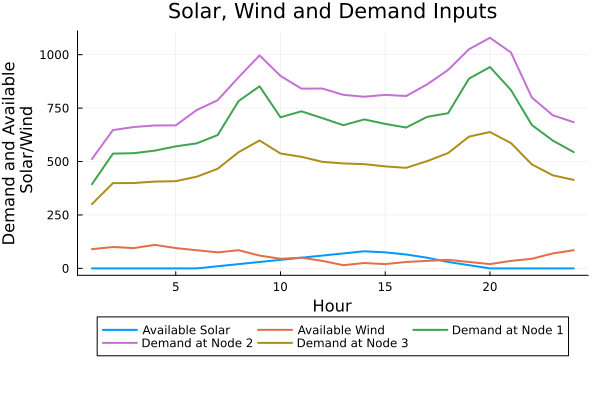

In [21]:
#Plotting the hourly demand and hourly available solar and wind generation
x = 1:HorizonTime
y1 = Solar_Max_Cap[:,1]
y2 = Wind_Max_Cap[:,3]
y3 = Node_Demand[:,1]
y4 = Node_Demand[:,2]
y5 = Node_Demand[:,3]

plot(x, [y1 y2 y3 y4 y5], label=["Available Solar" "Available Wind" "Demand at Node 1" "Demand at Node 2" "Demand at Node 3"], lw=repeat([2],1,5))
plot!(legend=:outerbottom, legendcolumns=3)
title!("Solar, Wind and Demand Inputs")
xlabel!("Hour")
ylabel!("Demand and Available\n Solar/Wind")

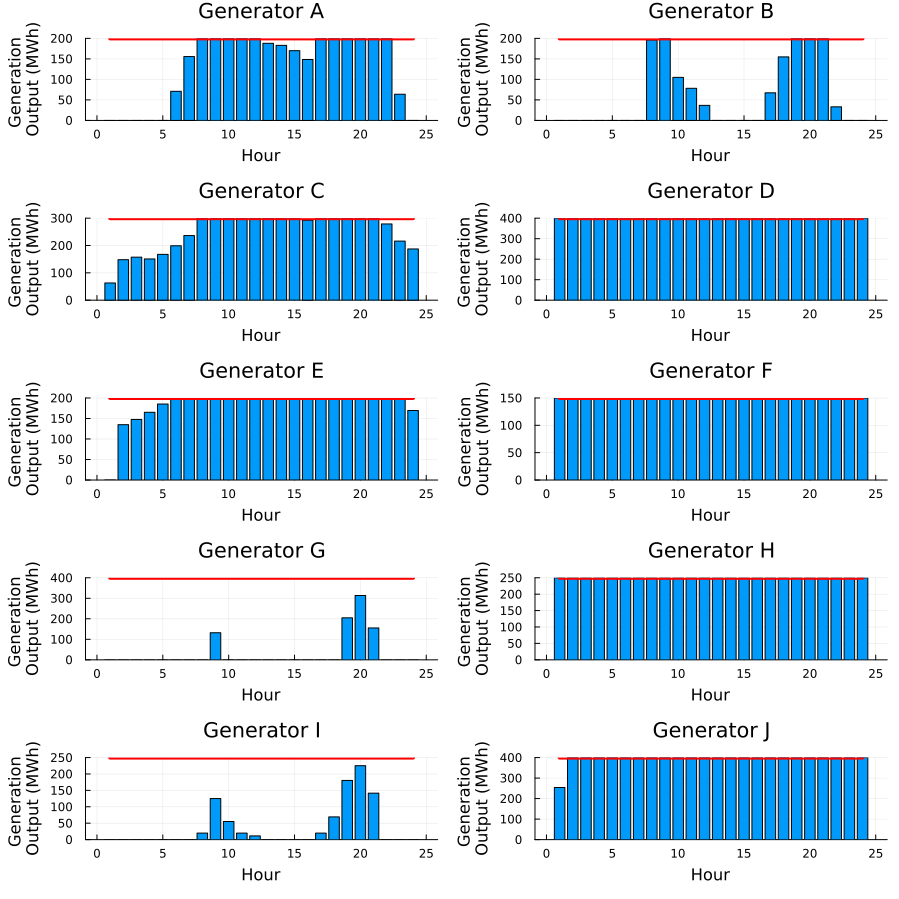

In [22]:
#Plotting hourly generation from each generator as bar plots (red line shows the maximum capacity)
x = 1:HorizonTime

y1 = Generation_output_df[:,1]
y2 = Generation_output_df[:,2]
y3 = Generation_output_df[:,3]
y4 = Generation_output_df[:,4]
y5 = Generation_output_df[:,5]
y6 = Generation_output_df[:,6]
y7 = Generation_output_df[:,7]
y8 = Generation_output_df[:,8]
y9 = Generation_output_df[:,9]
y10 = Generation_output_df[:,10]

All_max_caps_hourly = repeat(transpose(Gen_MaxCap), 24)
z1 = All_max_caps_hourly[:,1]
z2 = All_max_caps_hourly[:,2]
z3 = All_max_caps_hourly[:,3]
z4 = All_max_caps_hourly[:,4]
z5 = All_max_caps_hourly[:,5]
z6 = All_max_caps_hourly[:,6]
z7 = All_max_caps_hourly[:,7]
z8 = All_max_caps_hourly[:,8]
z9 = All_max_caps_hourly[:,9]
z10 = All_max_caps_hourly[:,10]

bar(x, [y1 y2 y3 y4 y5 y6 y7 y8 y9 y10], layout=(5, 2), legend=false, size=(900,900), ylabel="Generation \nOutput (MWh)", xlabel="Hour")
plot!(x, [z1 z2 z3 z4 z5 z6 z7 z8 z9 z10], layout=(5, 2), legend=false, lw=repeat([4],1,10), color="red", 
title=["Generator A" "Generator B" "Generator C" "Generator D" "Generator E" "Generator F" "Generator G" "Generator H" "Generator I" "Generator J"])

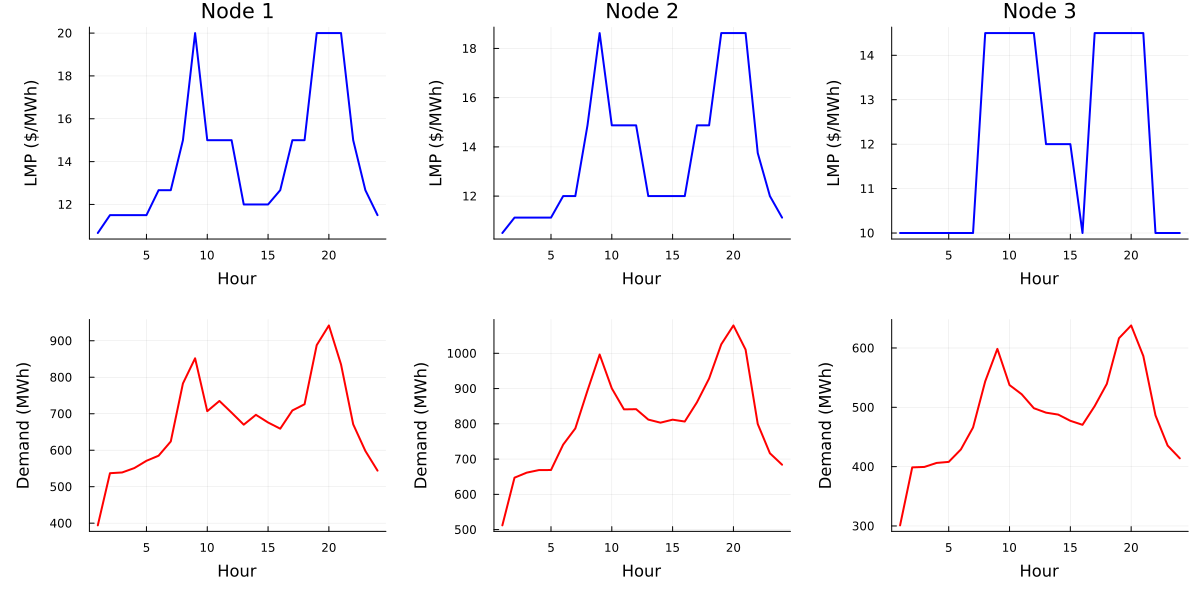

In [23]:
#Plotting hourly LMP and demand at each node
x = 1:HorizonTime
y1 = LMP_output_df[:,1]
y2 = LMP_output_df[:,2]
y3 = LMP_output_df[:,3]
y4 = Node_Demand[:,1]
y5 = Node_Demand[:,2]
y6 = Node_Demand[:,3]

plot(x, [y1 y2 y3 y4 y5 y6], lw=repeat([2],1,6), layout=(2, 3), legend=false, title=["Node 1" "Node 2" "Node 3" "" "" ""], size=(1200,600),
ylabel=["LMP (\$/MWh)" "LMP (\$/MWh)" "LMP (\$/MWh)" "Demand (MWh)" "Demand (MWh)" "Demand (MWh)"], xlabel="Hour", left_margin = 8Plots.mm, bottom_margin = 8Plots.mm,
color=["blue" "blue" "blue" "red" "red" "red"])

This is a simple example of how an ED model works. On top of these, we can extend 1 day simulation to 365 days by increasing the data size, and placing a for loop inside to select each day and filter all relevant data for that day, which goes into the optimization step. We can add other generators like nuclear and hydropower and storage technologies like batteries. We can make the model as complex as we would like. Moreover, we can write a unit commitment (UC) step where the solver assigns binary (1=generator is on, 0=generator is off) values to dispatchable generators. In this case, these binary decision variables would inform ED step afterwards. This would enable us to capture more advanced power generator costs such as start up costs, fixed costs, variable operation and maintenance costs as well as some constraints such as minimum up and down times as well as hurdle rates. Lastly, we can encapsulate these into custom structures and functions for tidiness and easy reproducibility. I am sharing an example of how a dispatchable generator structure and a transmission line structure would like below. We can create node, tranmission line and other structures that interact with one another and goes into a function where UC/ED model is solved. Since the scope of this file is to show how we can utilize Julia/JuMP to create production cost models (PCMs), these advanced steps are left as future works.

In [24]:
#Dispatchable generator structure example
struct DispatchableGen
    name :: String
    node :: Union{Int64, String}
    marginal_cost :: Union{Int64, Float64}
    max_capacity :: Union{Int64, Float64}
    min_capacity :: Union{Int64, Float64}
    function DispatchableGen(name::String, node::Union{Int64, String}, marginal_cost::Union{Int64, Float64}, max_capacity::Union{Int64, Float64}, min_capacity::Union{Int64, Float64}=0)
        new(name, node, marginal_cost, max_capacity, min_capacity)
    end
end

my_ex_gen = DispatchableGen("Gen_A", 123, 15, 200, 30)

DispatchableGen("Gen_A", 123, 15, 200, 30)

In [25]:
println("Name of my example generator is $(my_ex_gen.name)")
println("Node of my example generator is $(my_ex_gen.node)")
println("Marginal cost of my example generator is $(my_ex_gen.marginal_cost)")
println("Max capacity of my example generator is $(my_ex_gen.max_capacity)")
println("Min capacity of my example generator is $(my_ex_gen.min_capacity)")

Name of my example generator is Gen_A
Node of my example generator is 123
Marginal cost of my example generator is 15
Max capacity of my example generator is 200
Min capacity of my example generator is 30


In [26]:
#Transmission line structure example
struct TransmissionLine
    name :: Union{Int64, String}
    node_from :: Union{Int64, String}
    node_to :: Union{Int64, String}
    reactance :: Union{Int64, Float64}
    thermal_capacity :: Union{Int64, Float64}
    function TransmissionLine(name::Union{Int64, String}, node_from::Union{Int64, String}, node_to::Union{Int64, String}, reactance::Union{Int64, Float64}, thermal_capacity::Union{Int64, Float64})
        @assert thermal_capacity >= 0 "Thermal capacity of transmission line should be nonnegative."
        new(name, node_from, node_to, reactance, thermal_capacity)
    end
end

my_ex_line = TransmissionLine("Line_A", 3, 5, 0.5, 150)

TransmissionLine("Line_A", 3, 5, 0.5, 150)

In [27]:
println("Name of my example line is $(my_ex_line.name)")
println("My example line starts from node $(my_ex_line.node_from) and ends at node $(my_ex_line.node_to)")
println("Reactance of my example line is $(my_ex_line.reactance)")
println("Thermal capacity of my example line is $(my_ex_line.thermal_capacity)")

Name of my example line is Line_A
My example line starts from node 3 and ends at node 5
Reactance of my example line is 0.5
Thermal capacity of my example line is 150
